# Titanic competition

<a id="table_of_contents"></a>
## Table of contents

* [Titanic competition](#)
    * [Project overview](#project_overview)
        * [Short story](#)
        * [Goal](#)
        * [Data description](#)
    * [Introduce with data](#introduce)
        * [Import libs](#import_libs)
        * [Import data and first impression](#import_data)
        * [Brief conclusions](#brief_conclusions)
    * [Data analysis](#data_preparation)
        * [Categorial features](#)
        * [Numeric features](#)
        * [Fill NA](#)
        * [Multicolleniar](#)

<a id="project_overview"></a>
## Project overview

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

<a id="data_description"></a>
### Data description

#### Variables


|# | Variable | Definition | Key |
|:-|:---------|:-----------|:----|		
|1 | survival |	Survival   | 0 = No, 1 = Yes |
|2 | pclass |	Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|3 | sex |	Sex | |	
|4 | Age |	Age in years | | 	
|5 | sibsp | # of siblings / spouses aboard the Titanic | |
|6 | parch | # of parents / children aboard the Titanic | | 	
|7 | ticket | Ticket number | |
|8 | fare | Passenger fare | |
|9 | cabin | Cabin number | |
|10 | embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |


#### Variable Notes

    pclass: A proxy for socio-economic status (SES)
    1st = Upper
    2nd = Middle
    3rd = Lower

    age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

    sibsp: The dataset defines family relations in this way...
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

    parch: The dataset defines family relations in this way...
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

[to the table of contents](#table_of_contents)


<a id="introduce"></a>
## Introduce with data

<a id="import_libs"></a>
### Import libs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import RandomState

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="import_data"></a>
### Import data and first impression

In [2]:
# let's check which files do we have
datasets_dir = '../datasets/titanic'

if not os.path.isdir(datasets_dir):
    datasets_dir = '/kaggle/input'
    
for dirname, _, filenames in os.walk(datasets_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../datasets/titanic/test.csv
../datasets/titanic/train.csv
../datasets/titanic/gender_submission.csv


#### Train dataset

In [3]:
# upload train dataset
df_train = pd.read_csv(os.path.join(datasets_dir, 'train.csv'))

# check shape of the dataset
print('Shape of the train dataset:', df_train.shape, end='\n\n')

# watch first 10 rows
print('First five rows of the train dataset:')
display(df_train.head(10))

Shape of the train dataset: (891, 12)

First five rows of the train dataset:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# train dataset info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Test dataset

In [4]:
# upload gender test dataset
df_test = pd.read_csv(os.path.join(datasets_dir, 'test.csv'))

# check shape of the dataset
print('Shape of the test dataset:', df_test.shape, end='\n\n')

# watch first 10 rows in it
print('First five rows in the test dataset:')
display(df_test.head(10))

Shape of the test dataset: (418, 11)

First five rows in the test dataset:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [5]:
# test dataset info
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Gender submission

In [6]:
# upload gender submission dataset
df_gender = pd.read_csv(os.path.join(datasets_dir, 'gender_submission.csv'))

# check shape of the dataset
print('Shape of the gender_submission dataset:', df_gender.shape, end='\n\n')

# watch first 5 rows in it
print('First five rows in the gender submission dataset:')
display(df_gender.head())

Shape of the gender_submission dataset: (418, 2)

First five rows in the gender submission dataset:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<a id="brief_conclusions"></a>
### Brief conclusions

So...

[to the table of contents](#table_of_contents)

<a id="data_preparation"></a>
## Data preparation

### Target feature

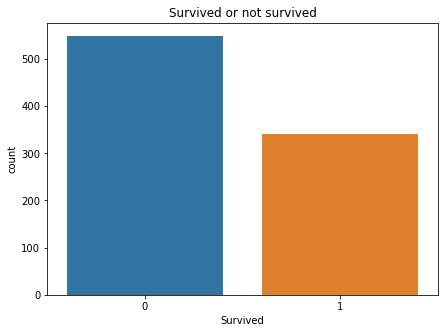

In [9]:
# Let's compare the number of survivos and the number of deceased on the graph:
plt.figure(figsize=(7,5))
sns.countplot(x='Survived', data=df_train)
plt.title('Survived or not survived')
plt.show()

Unfortunately, the number of survivors is significantly less than the number of deceased.

### Duplicates
Let's check are there duplicates or not?

In [9]:
print(df_train.duplicated().sum())

0


#### Hidden duplicates

There is not any hidden duplicate

### Categorial features

In [11]:
cat_features = ['Pclass', 'Sex', 'Embarked']

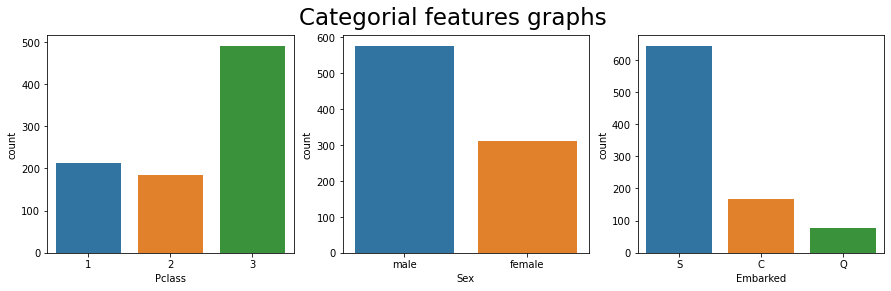

In [12]:
# create figure with three slots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# do the monomer massive from the axis
for i, ax in enumerate(axes.flat):
    sns.countplot(x=cat_features[i], data=df_train[cat_features].dropna(axis=0), ax=ax)
    
fig.suptitle('Categorial features graphs', fontsize=23)
plt.show()

#### Let's plot categorial features by target

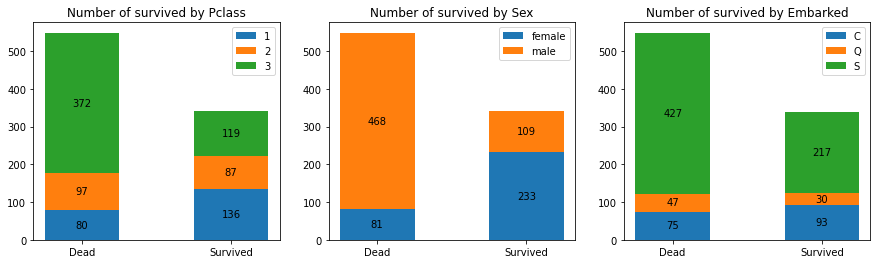

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for i, column in enumerate(cat_features):
    df = df_train.pivot_table(index='Survived', columns=column, aggfunc='count')['PassengerId']
    ax = axes[i]
    bottom = np.zeros(2)
    width = 0.5
    species = ('Dead', 'Survived')
    for clmn, array in df.items():
        p = ax.bar(species, array, width, label=clmn, bottom=bottom)
        bottom += array
        ax.bar_label(p, label_type='center')
        
    ax.set_title(f'Number of survived by {column}')
    ax.legend()
    
plt.show()

#### Let's plot target by categorial features:

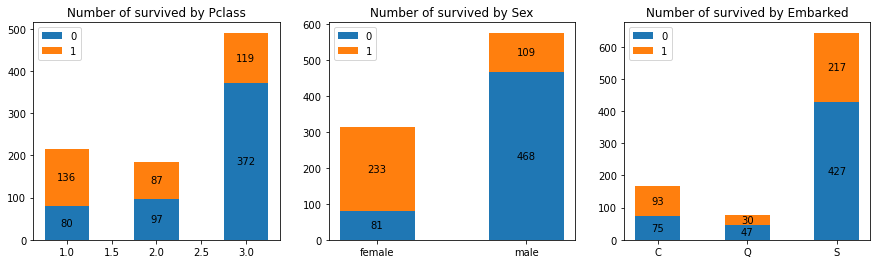

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

for i, column in enumerate(cat_features):
    df = df_train.pivot_table(index=column, columns='Survived', aggfunc='count')['PassengerId']
    ax = axes[i]
    bottom = np.zeros(len(df))
    width = 0.5
    species = df.index.values
    for clmn_name, clmn_values in df.items():
        p = ax.bar(species, clmn_values, width, label=clmn_name, bottom=bottom)
        bottom += clmn_values
        ax.bar_label(p, label_type='center')
        
    ax.set_title(f'Number of survived by {column}')
    ax.legend()

plt.show()

<a id="brief_conclusions_categorial_features"></a>
#### Brief conclusions

So, we can see that most part of deasesed is the third class passangers. 

#### Cabin

In [15]:
df_train['HasCabin'] = np.where(df_train['Cabin'].isna(), 'doesnt', 'has cabin')

In [16]:
display(df_train['HasCabin'].value_counts())

doesnt       687
has cabin    204
Name: HasCabin, dtype: int64

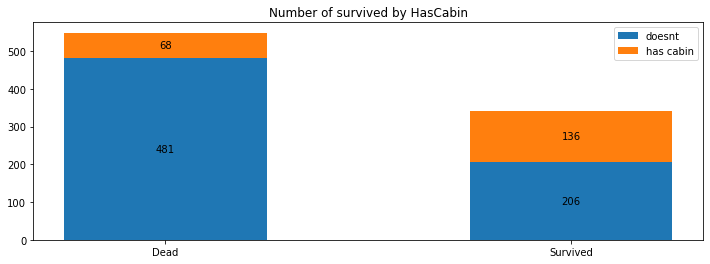

In [19]:
f, ax = plt.subplots(figsize=(12, 4))
df = df_train.pivot_table(index='Survived', columns='HasCabin', aggfunc='count')['PassengerId']

bottom = np.zeros(2)
width = 0.5
species = ('Dead', 'Survived')
for clmn, array in df.items():
    p = ax.bar(species, array, width, label=clmn, bottom=bottom)
    bottom += array
    ax.bar_label(p, label_type='center')

ax.set_title(f'Number of survived by HasCabin')
ax.legend()

plt.show()

In [20]:
df_train['Cabin'] = df_train['Cabin'].fillna('hz')
df_train['CabinLatter'] = df_train['Cabin'].str[0]
print(df_train['CabinLatter'].value_counts())

h    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: CabinLatter, dtype: int64


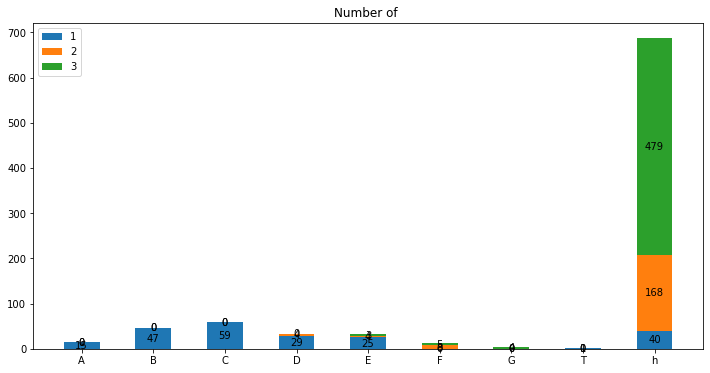

In [25]:
f, ax = plt.subplots(figsize=(12, 6))
df = df_train.pivot_table(index='CabinLatter', columns='Pclass', aggfunc='count')['PassengerId']
df = df.fillna(0)

bottom = np.zeros(len(df))
width = 0.5
species = df.index.values
for clmn, array in df.items():
    p = ax.bar(species, array, width, label=clmn, bottom=bottom)
    bottom += array
    ax.bar_label(p, label_type='center')

ax.set_title(f'Number of ')
ax.legend()

plt.show()

In [22]:
display(df)

Pclass,1,2,3
CabinLatter,,,
A,15.0,NaN,NaN
B,47.0,NaN,NaN
C,59.0,NaN,NaN
D,29.0,4.0,NaN
E,25.0,4.0,3.0
F,NaN,8.0,5.0
G,NaN,NaN,4.0
T,1.0,NaN,NaN
h,40.0,168.0,479.0


### Numerical features

Let's plot 

In [14]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

In [15]:
display(df_train[num_features].describe())

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


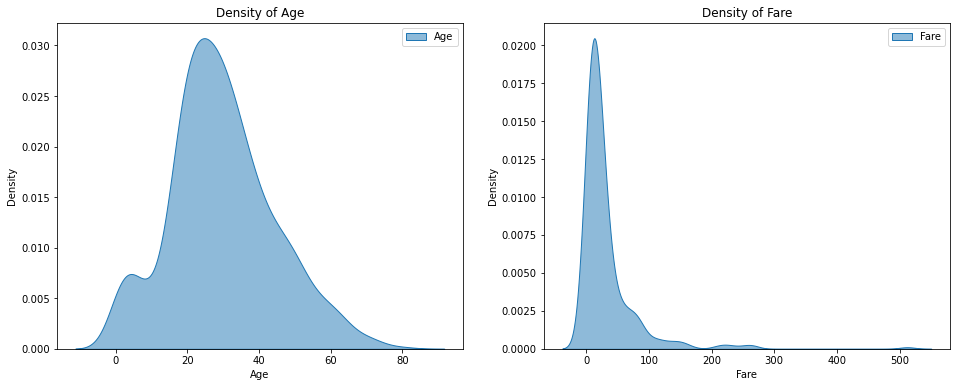

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, feature in enumerate(['Age', 'Fare']):
    ax = axes.flat[i]
    sns.kdeplot(df_train[feature]
               , gridsize=500
               , bw_adjust=1
               , common_grid=True
               , fill=True
               , alpha=0.5
               , label=feature
               , ax=ax)
    ax.set_title(f'Density of {feature}')
    ax.legend()


plt.show()

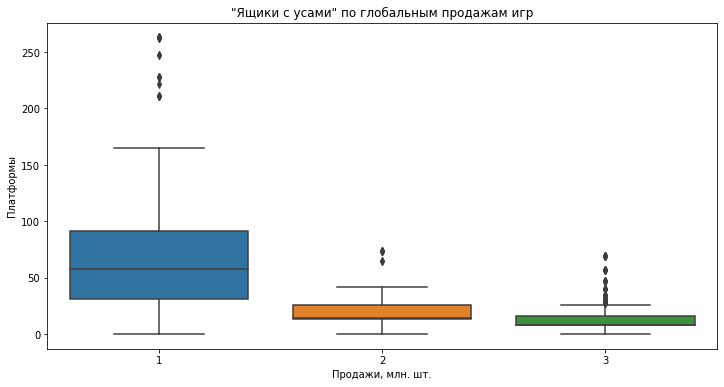

In [26]:
# import seaborn as sns

plt.figure(figsize=(12, 6))

sns.boxplot(data=df_train, x='Pclass',y='Fare')

plt.title('"Ящики с усами" по глобальным продажам игр')
plt.xlabel('Продажи, млн. шт.')
plt.ylabel('Платформы')

plt.show()

In [21]:
df_train['CabinLatter'] = df_train['Cabin'].str[0]
print(df_train['CabinLatter'].value_counts())

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: CabinLatter, dtype: int64


In [24]:
df_train = df_train[df_train['Fare'] < 300]

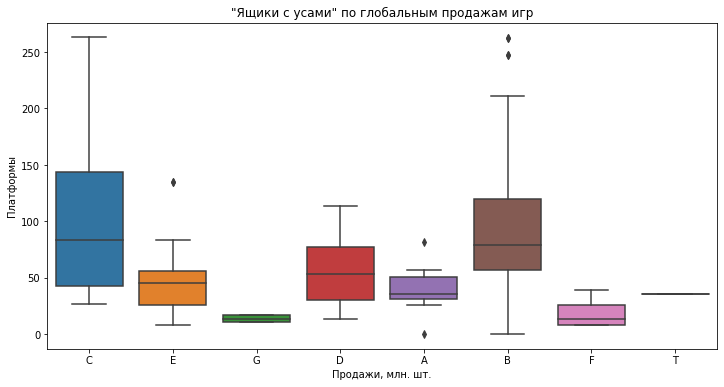

In [25]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_train, x='CabinLatter',y='Fare')

plt.title('"Ящики с усами" по глобальным продажам игр')
plt.xlabel('Продажи, млн. шт.')
plt.ylabel('Платформы')

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, feature in enumerate(['SibSp', 'Parch']):
    ax = axes.flat[i]
    sns.countplot(x=feature, data=df_train, hue=feature, ax=ax)
    ax.set_title(f'Density of {feature}')
    ax.legend()

plt.show()


In [ ]:
matrix = phik_matrix(df_train.drop(['PassengerId', 'Name', 'Ticket'], axis=1), interval_cols = ['Age', 'Fare'])
display(matrix)

In [ ]:
# Построим график:

plot_correlation_matrix(np.array(matrix)
                        , x_labels=matrix.columns
                        , y_labels=matrix.index
                        , vmin=0
                        , vmax=1
                        , color_map="Greens"
#                         , title=r"correlation $\phi_K$"
                        , fontsize_factor=1.5
                        , figsize=(9, 8))
plt.title(r"correlation $\phi_K$", size=23)
plt.tight_layout()

### Fill na

#### Embarked

In [ ]:
display(df_train[df_train['Embarked'].isnull()])

In [ ]:
display(df_train[df_train['Cabin']=='B28'])

In [ ]:
df_train.head(20)

In [ ]:
df_train['Age'].fillna()

In [ ]:
df_train['Age'] = df_train.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
df_train['Cabin'] = df_train['Cabin'].fillna('hz')

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  888 non-null    int64  
 1   Survived     888 non-null    int64  
 2   Pclass       888 non-null    int64  
 3   Name         888 non-null    object 
 4   Sex          888 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        888 non-null    int64  
 7   Parch        888 non-null    int64  
 8   Ticket       888 non-null    object 
 9   Fare         888 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     886 non-null    object 
 12  CabinLatter  202 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 129.4+ KB


## Models

In [ ]:
RANDOM_STATE = 232111

In [ ]:
features = df_train.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)
target = df_train['Survived']


print(features.shape)
print(target.shape)

In [ ]:
numeric_columns = ['Age', 'SibSp', 'Parch', 'Fare']
categ_columns = list(features.columns)
for column in numeric_columns:
    categ_columns.remove(column)

print('Numeric params:')
print(*numeric_columns)
print('\n')
print('Categorial params:')
print(*categ_columns)

In [ ]:
%%time
column_trans = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_columns),
    ('categorial', OneHotEncoder(drop='first'), categ_columns)
])


# Создание пайплайна для последовательного выполнения препроцессора и модели
pipeline = Pipeline([
    ('column_trans', column_trans),
    ('logreg', LogisticRegression(random_state = RANDOM_STATE))
])

# Определение сетки параметров для GridSearchCV
param_grid = {
    'logreg__C': [0.1, 1, 10]
}

# Создание объекта GridSearchCV
gs_logreg = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=False)

# Обучаем модель на тренировочных данных
gs_logreg.fit(train_features, train_target)

# # Лучшие параметры модели
# best_params = gs_logreg.best_params_

# # Лучшая модель
# best_model = gs_logreg.best_estimator_


# Выводим наилучшие параметры и оценку метрики 
print("Best parameters: ", gs_logreg.best_params_)
print("Best AUC_ROC: ", gs_logreg.best_score_)